# SpatialGLUE

In [1]:
import SpatialGlue

import os
import torch
import pandas as pd
import scanpy as sc

# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' clustering algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/home/wuxinchao/software/miniconda3/bin/R'

In [30]:
# read data
file_fold = '/home/wuxinchao/data/st_cite_data/B01825A4/'

# adata_omics1 = sc.read_h5ad(file_fold + 'B01825A4_RNA_mouse_thymus_bin100.h5ad')
# adata_omics2 = sc.read_h5ad(file_fold + 'B01825A4_Port_mouse_thymus_bin100.h5ad')

adata_omics1 = sc.read_h5ad(file_fold + 'B01825A4_RNA_mouse_thymus_bin20.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'B01825A4_Port_mouse_thymus_bin20.h5ad')


adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

In [31]:
# Specify data type
data_type = 'Stereo-CITE-seq'

# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)

## Preprocessing

In [33]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca

# RNA
# sc.pp.filter_genes(adata_omics1, min_cells=10)
# sc.pp.filter_cells(adata_omics1, min_genes=80)
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.filter_cells(adata_omics1, min_genes=10) # For bin20

# Protein
sc.pp.filter_genes(adata_omics2, min_cells=50)

intersect = adata_omics2.obs_names.intersection(adata_omics1.obs_names)
print(len(intersect))

adata_omics1 = adata_omics1[intersect].copy()
adata_omics2 = adata_omics2[intersect].copy()

133758


In [36]:
# RNA
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars-1)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

In [37]:
## Constructing neighbor graph
from SpatialGlue.preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type)

## Training model

In [ ]:
# define model
from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
model = Train_SpatialGlue(data, datatype=data_type, device=device)

# train model
output = model.train()

  0%|          | 0/1500 [00:00<?, ?it/s]/home/wuxinchao/software/miniconda3/envs/spatialGlue/lib/python3.8/site-packages/SpatialGlue/model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 1500/1500 [01:21<00:00, 18.30it/s]


Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata.obsm['SpatialGlue'] = output['SpatialGlue']
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

## Cross-modality integrative analysis

In [ ]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'leiden' # mclust, leiden, and louvain
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=8, method=tool, use_pca=True, end=0.9)

Searching resolution...
resolution=0.9899999999999995, cluster number=14
resolution=0.9799999999999995, cluster number=13
resolution=0.9699999999999995, cluster number=14
resolution=0.9599999999999995, cluster number=14
resolution=0.9499999999999995, cluster number=14
resolution=0.9399999999999996, cluster number=12
resolution=0.9299999999999996, cluster number=12
resolution=0.9199999999999996, cluster number=14
resolution=0.9099999999999996, cluster number=11
resolution=0.8999999999999996, cluster number=12
resolution=0.8899999999999996, cluster number=12
resolution=0.8799999999999996, cluster number=12
resolution=0.8699999999999996, cluster number=12
resolution=0.8599999999999995, cluster number=12
resolution=0.8499999999999996, cluster number=10
resolution=0.8399999999999996, cluster number=11
resolution=0.8299999999999996, cluster number=8


/home/wuxinchao/software/miniconda3/envs/spatialGlue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wuxinchao/software/miniconda3/envs/spatialGlue/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


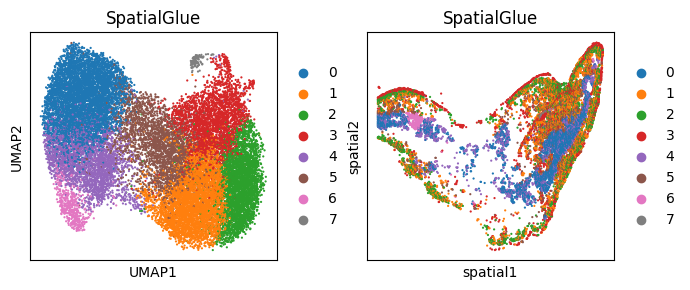

In [ ]:
# visualization
import matplotlib.pyplot as plt
# adata.obsm['spatial'][:,1] = -1*adata.obsm['spatial'][:,1]

fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=30)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=10, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=10, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [ ]:
# annotation
adata.obs['SpatialGlue_number'] = adata.obs['SpatialGlue'].copy()

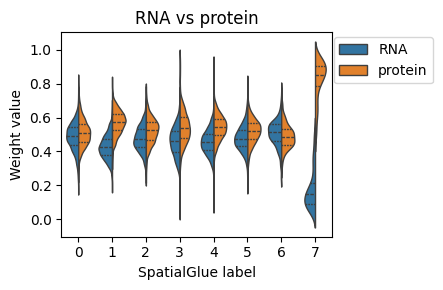

In [ ]:
# plotting modality weight values.
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (5,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata.obsm['alpha'][:, 0], adata.obsm['alpha'][:, 1]
df['label'] = adata.obs['SpatialGlue_number'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title('RNA vs protein')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()

In [ ]:
adata.write_h5ad(f"{file_fold}SpatialGlue_bin20.h5ad")

# MOFA+

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
from muon import prot as pt

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_fold = "/home/wuxinchao/data/st_cite_data/B01825A4/"

mdata = mu.read_h5mu(f"{file_fold}B01825A4_bin100_processed.h5mu")
mdata

MuData object with n_obs × n_vars = 4499 × 26017
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	4499 x 25818
      obs:	'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'__type', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap'
      obsm:	'X_pca', 'X_umap', 'bbox', 'contour', 'spatial'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	4499 x 199
      obs:	'area', 'n_genes_by_counts', 'total_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'__type', 'log1p', 'pp', 'spatial'
      obsm:	'bbox', 'contour', 'spatial'
      layers:	'counts'

In [3]:
prot = mdata.mod['protein']
sc.tl.pca(prot)
sc.pp.neighbors(prot)
sc.tl.umap(prot, random_state=1)

In [4]:
rna = mdata.mod['rna']

In [5]:
rna.X = rna.layers["counts"]
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:241: RuntimeWarning: invalid value encountered in divide
  df['dispersions_norm'] = (


In [7]:
sc.tl.pca(rna, svd_solver='arpack')
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna, resolution=.75)
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

In [8]:
mu.pp.intersect_obs(mdata)
# mu.tl.louvain(mdata, resolution=[2, .1], random_state=1)
mu.tl.leiden(mdata, resolution=[2, .1], random_state=1)

/home/wuxinchao/software/miniconda3/envs/mofa2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


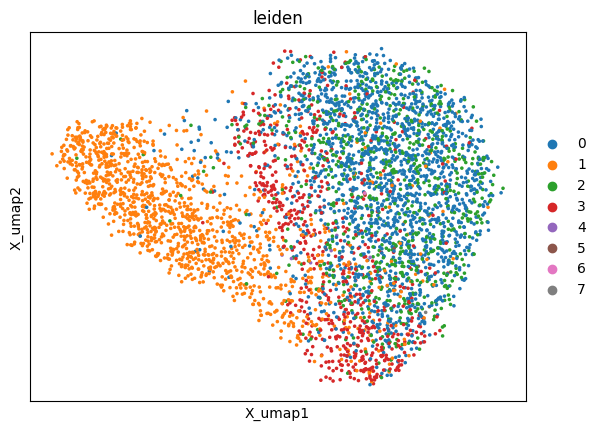

In [9]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["leiden"])
prot.var["highly_variable"] = True
mdata.update()

In [66]:
mdata.var["highly_variable"] = mdata.var["highly_variable"].astype(bool)

In [67]:
mu.tl.mofa(mdata, n_factors=30)
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=4499 samples and D=2407 features...
Loaded view='protein' group='group1' with N=4499 samples and D=199 features...



Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights

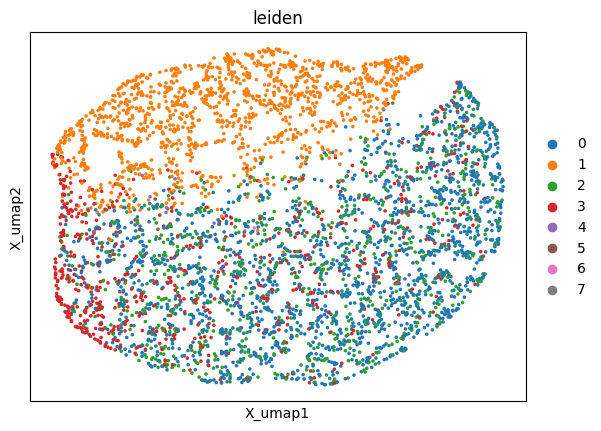

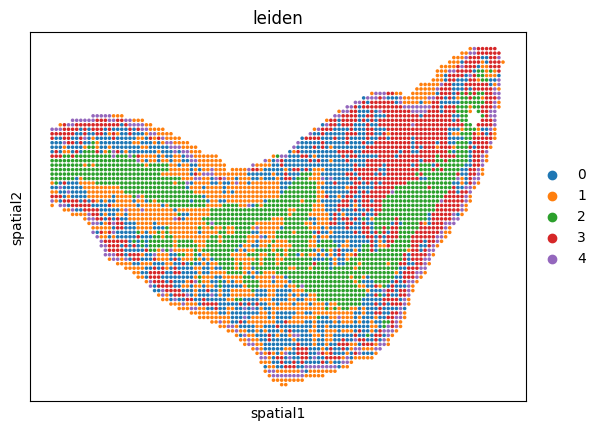

In [72]:
sc.pl.embedding(mdata, basis="X_umap", color=["leiden"])
sc.pl.embedding(mdata['rna'], basis="spatial", color=["leiden"])

In [94]:
mdata.obs["leiden_mofa"] = mdata.obs["leiden"]

In [86]:
# Save the MOFA results
np.savez(f"{file_fold}mofa_results.npz", factors=mdata.obsm["X_mofa"], 
            weights=mdata.varm["LFs"], leiden_results=mdata.obs["leiden"])

## WNN

In [88]:
sc.pp.neighbors(mdata['rna'])
sc.pp.neighbors(mdata['protein'])

# Calculate weighted nearest neighbors
mu.pp.neighbors(mdata, key_added='wnn')

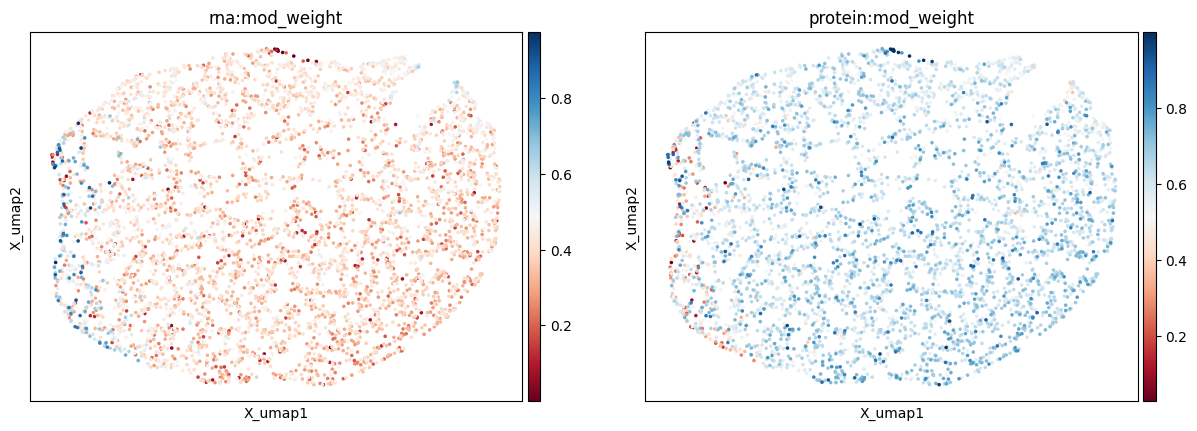

In [90]:
mu.pl.umap(mdata, color=['rna:mod_weight', 'protein:mod_weight'], cmap='RdBu')

In [91]:
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')

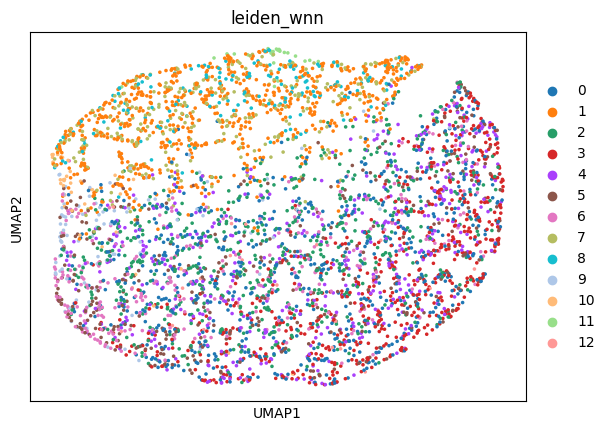

In [93]:
sc.pl.embedding(mdata, basis="umap", color=["leiden_wnn"])

In [97]:
mdata.write_h5mu(f"{file_fold}B01825A4_bin100_processed_results.h5mu")

# TotalVI

In [72]:
import numpy as np
import muon as mu
import scanpy as sc
import scvi

In [10]:
file_fold = '/home/wuxinchao/data/st_cite_data/B01825A4/'
mdata = mu.read_h5mu(f"{file_fold}B01825A4_bin100_processed_results.h5mu")
mdata

MuData object with n_obs × n_vars = 4499 × 26017
  obs:	'leiden', 'leiden_wnn', 'leiden_mofa'
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
  uns:	'leiden', 'leiden_colors', 'leiden_wnn_colors', 'mofa', 'neighbors', 'umap', 'wnn'
  obsm:	'X_mofa', 'X_umap'
  varm:	'LFs'
  obsp:	'connectivities', 'distances', 'wnn_connectivities', 'wnn_distances'
  2 modalities
    rna:	4499 x 25818
      obs:	'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'dispersions', 'dispersions_norm'
      uns:	'__type', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap'
      obsm:	'X_pca', 'X_umap', 'bbox', 'contour', 'spatial'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	4499 x 199
      obs:	'area', 'n_genes_by_counts', 'total_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
      uns:	'__type', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap'
      obsm:	'X_pca', 'X_umap', 'bbox', 'contour', 'spatial'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

In [11]:
sc.pp.filter_genes(mdata["protein"], min_cells=50)

In [12]:
# Place subsetted counts in a new modality
mdata.mod["rna_subset"] = mdata.mod["rna"][
    :, mdata.mod["rna"].var["highly_variable"]
].copy()

In [13]:
mdata["rna_subset"].layers["counts"] = mdata["rna_subset"].layers["counts"].toarray()
mdata["protein"].layers["counts"] = mdata["protein"].layers["counts"].toarray()

In [20]:
mdata.update()

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [21]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer="counts",
    modalities={
        "rna_layer": "rna_subset",
        "protein_layer": "protein",
    },
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [22]:
model = scvi.model.TOTALVI(mdata)

INFO     Computing empirical prior initialization for protein background.                                          


In [23]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:321: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [02:44<00:00,  2.52it/s, v_num=1, train_loss_step=602, train_loss_epoch=595]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:44<00:00,  2.43it/s, v_num=1, train_loss_step=602, train_loss_epoch=595]


In [24]:
rna = mdata.mod["rna_subset"]
protein = mdata.mod["protein"]

In [25]:
rna_denoised, protein_denoised = model.get_normalized_expression(
    n_samples=25, return_mean=True,
)
rna.layers["denoised_rna"] = rna_denoised
protein.layers["denoised_protein"] = protein_denoised

protein.layers["protein_foreground_prob"] = (
    100
    * model.get_protein_foreground_probability(
        n_samples=25, return_mean=True,
    )
)

In [26]:
TOTALVI_CLUSTERS_KEY = "leiden_totalVI"
TOTALVI_LATENT_KEY = "X_totalVI"

rna.obsm[TOTALVI_LATENT_KEY] = model.get_latent_representation()

sc.pp.neighbors(rna, use_rep=TOTALVI_LATENT_KEY)
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added=TOTALVI_CLUSTERS_KEY)

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


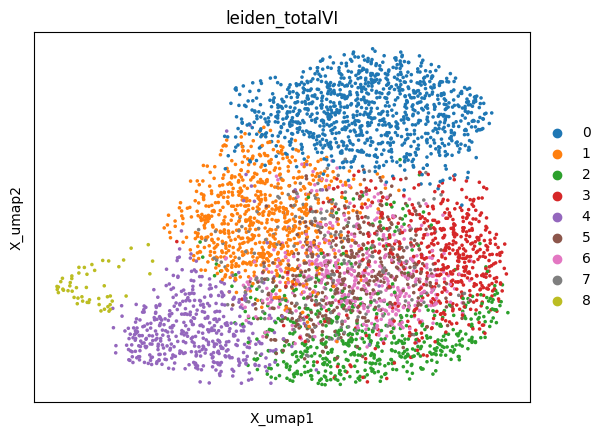

In [29]:
sc.pl.embedding(rna, basis="X_umap", color=TOTALVI_CLUSTERS_KEY)
# sc.pl.embedding(rna, basis="totalVI", color=TOTALVI_CLUSTERS_KEY)

In [30]:
import numpy as np

np.savez(f"{file_fold}B01825A4_bin100_processed_results_totalVI.npz", totalVI=rna.obsm["X_totalVI"])

In [33]:
mdata.update()

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [34]:
de_df = model.differential_expression(
    groupby="rna_subset:leiden_totalVI", delta=0.5, batch_correction=True
)
de_df.head(5)

DE...: 100%|██████████| 9/9 [00:19<00:00,  2.11s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
Wfdc18,0.9754,0.0246,3.680101,0.002151,0.000121,0.0,0.5,5.568797,5.437843,3.106910,-10.199171,18.716549,0.639614,0.018476,0.378744,0.015300,21.482088,1.012464,True,0 vs Rest,0,Rest
Csn2,0.9736,0.0264,3.607636,0.001814,0.000121,0.0,0.5,5.662830,5.494026,3.273150,-8.426376,19.847279,0.499517,0.021651,0.290821,0.015589,17.281570,0.941837,True,0 vs Rest,0,Rest
Ccl22,0.9710,0.0290,3.511030,0.000980,0.000078,0.0,0.5,4.811058,4.714159,2.839037,-4.305054,17.264282,0.342029,0.014145,0.235749,0.012991,11.025479,0.555817,True,0 vs Rest,0,Rest
Aire,0.9648,0.0352,3.310874,0.000528,0.000058,0.0,0.5,5.140211,4.962467,3.526246,-8.930719,20.616131,0.170048,0.011259,0.142029,0.008372,5.650644,0.495079,True,0 vs Rest,0,Rest
S100a14,0.9632,0.0368,3.264763,0.000837,0.000096,0.0,0.5,3.817722,3.702128,2.392294,-7.348307,13.401808,0.263768,0.019919,0.200966,0.017610,8.747737,0.892465,True,0 vs Rest,0,Rest


In [35]:
filtered_pro = {}
filtered_rna = {}
cats = rna.obs[TOTALVI_CLUSTERS_KEY].cat.categories
for i, c in enumerate(cats):
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.str.contains("TotalSeqB")
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

In [36]:
sc.tl.dendrogram(rna, groupby=TOTALVI_CLUSTERS_KEY, use_rep=TOTALVI_LATENT_KEY)
# This is a bit of a hack to be able to use scanpy dendrogram with the protein data
protein.obs[TOTALVI_CLUSTERS_KEY] = rna.obs[TOTALVI_CLUSTERS_KEY]
protein.obsm[TOTALVI_LATENT_KEY] = rna.obsm[TOTALVI_LATENT_KEY]
sc.tl.dendrogram(protein, groupby=TOTALVI_CLUSTERS_KEY, use_rep=TOTALVI_LATENT_KEY)

In [50]:
mdata.update()

In [82]:
protein

AnnData object with n_obs × n_vars = 4499 × 48
    obs: 'area', 'n_genes_by_counts', 'total_counts', '_scvi_batch', 'leiden_totalVI'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'n_cells'
    uns: '__type', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap', 'dendrogram_leiden_totalVI'
    obsm: 'X_pca', 'X_umap', 'bbox', 'contour', 'spatial', 'X_totalVI'
    varm: 'PCs'
    layers: 'counts', 'denoised_protein', 'protein_foreground_prob'
    obsp: 'connectivities', 'distances'

In [83]:
# mdata
np.savez(f"{file_fold}B01825A4_bin100_totalVI_results.npz)", 
    totalVI=rna.obsm["X_totalVI"], 
    rna_denoised=rna.layers["denoised_rna"], 
    protein_denoised=protein.layers["denoised_protein"],
    )

In [70]:
mudata = mu.MuData(
    {
        "rna": mdata["rna"],
        "protein": mdata["protein"],
    }
)

In [71]:
mudata.write_h5mu(f"{file_fold}B01825A4_bin100_processed_results_totalVI.h5mu")

# StGCAT

In [1]:
import muon as mu
import scanpy as sc
import matplotlib.pyplot as plt
import torch

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_fold = '/home/wuxinchao/data/st_cite_data/B01825A4/'
mdata = mu.read_h5mu(f"{file_fold}B01825A4_bin100_processed_results_totalVI.h5mu")
mdata

MuData object with n_obs × n_vars = 4499 × 25866
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
  2 modalities
    rna:	4499 x 25818
      obs:	'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'dispersions', 'dispersions_norm'
      uns:	'__type', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap'
      obsm:	'X_pca', 'X_umap', 'bbox', 'contour', 'spatial'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	4499 x 48
      obs:	'area', 'n_genes_by_counts', 'total_counts', '_scvi_batch', 'leiden_totalVI'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'n_cells'
      uns:	'__type', 'dendrogram_leiden_totalVI', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap'
      obsm:	'X_pca', 'X_totalVI', 'X_umap', 'bbox', 'contour', 'spatial'
      varm:	'PCs'
      layers:	'counts', 'denoised_protein', 'protein_foreground_prob'
      obsp:	'connectivities', 'distances'

In [15]:
import importlib
import sys

importlib.reload(sys.modules['models.train'])
importlib.reload(sys.modules['models.model'])

<module 'models.model' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/models/model.py'>

In [16]:
from models.dataset import create_graphData_mu, split_data

num_splits = 1
num_val = 0.2
num_test = 0.2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

# graph_data = create_graphData(rna_adata_pool_subset, protein_adata_intersect, device)
graph_data, rna_input_dim, prot_input_dim = create_graphData_mu(mdata, features_use="highly_variable", device=device)
training_data = split_data(graph_data, num_splits=num_splits, num_val=num_val, num_test=num_test)

In [17]:
from models.train import Trainer

model_choice = "Graph Cross Attention"

hidden_dim = 256
embedding_dim = 256
heads = 8
num_blocks = 4
permute = True
preserve_rate = 0.9
alpha = 0.6
beta = 0.1

# setting for the trainer
batch_size = 256
lr = 1e-4
epochs = 10
mask_ratio = 0.85
GAT_encoding = True
return_attention_weights = False

trainer = Trainer(
    training_data,
    model_choice=model_choice,
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
    GAT_encoding=GAT_encoding,
    return_attention_weights=False,
)

trainer.train(plot_loss=False)

Epoch 1/10 train_loss: 77.55774 val_loss: 12.08380
Epoch 2/10 train_loss: 36.15568 val_loss: 6.13018
Epoch 3/10 train_loss: 26.95982 val_loss: 5.45663
Epoch 4/10 train_loss: 25.67815 val_loss: 5.22678
Epoch 5/10 train_loss: 25.37198 val_loss: 5.14726
Epoch 6/10 train_loss: 25.09139 val_loss: 5.05968
Epoch 7/10 train_loss: 25.17878 val_loss: 5.11780
Epoch 8/10 train_loss: 24.97032 val_loss: 5.12650
Epoch 9/10 train_loss: 24.94302 val_loss: 5.14016
Epoch 10/10 train_loss: 25.09042 val_loss: 5.12112
Best model saved at split 0


In [19]:
mdata.obsm["GCAT_embedding"] = trainer.get_embedding(graph_data)

In [43]:
# Clustering based on the embedding
# sc.pp.neighbors(mdata, use_rep="GCAT_embedding", key_added="GCAT_neighbors")
# sc.tl.umap(mdata, random_state=1, neighbors_key="GCAT_neighbors")
sc.tl.leiden(mdata, resolution=0.6, random_state=1, 
            neighbors_key='GCAT_neighbors', key_added="GCAT_leiden")

In [33]:
mdata.obsm['spatial'] = mdata['rna'].obsm["spatial"]

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


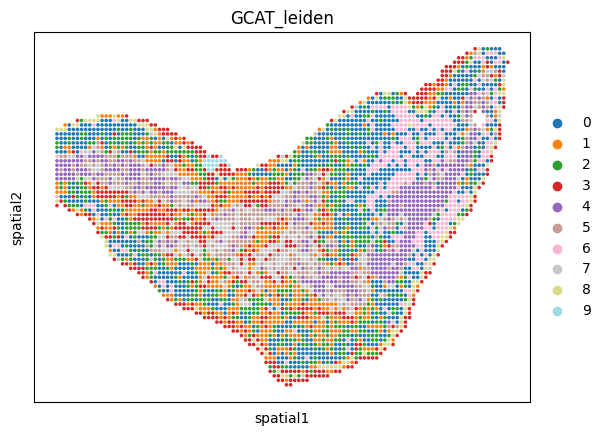

In [48]:
sc.pl.embedding(mdata, basis="spatial", color="GCAT_leiden", palette="tab20")

# Metrics

In [50]:
from sklearn.metrics import v_measure_score, silhouette_score, adjusted_rand_score, adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score

In [27]:
def choose_embedding(key, mudata):
    # unsupervised metrics
    embedding = mudata.obsm[key]
    labels_pred = mudata.obs[key]
    silhouette_avg = silhouette_score(embedding, labels_pred)
    calinski_harabasz = calinski_harabasz_score(embedding, labels_pred)
    davies_bouldin = davies_bouldin_score(embedding, labels_pred)
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz}')
    print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.22110171616077423
Calinski-Harabasz Index: 2348.4569644591347
Davies-Bouldin Index: 1.4429402619541631


In [ ]:
# # Supervised metrics
# v_measure = v_measure_score(labels_true, labels_pred)
# ari = adjusted_rand_score(labels_true, labels_pred)
# ami = adjusted_mutual_info_score(labels_true, labels_pred)

# print(f'V-measure: {v_measure}')
# print(f'Adjusted Rand Index (ARI): {ari}')
# print(f'Adjusted Mutual Information (AMI): {ami}')

In [ ]:
# Benchmark the clustering results for bin100 data
# Load the embedding and predict labels


In [ ]:
# Plot the barplot for the unsupervised metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a dictionary with the metrics